Load data from yahoo finance

In [1]:
!pip install yfinance

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf

In [3]:
#Shanghai Composite Index
# ticker '000001.SS'
SSE=yf.download('000001.SS','2010-01-05',end='2021-01-05')
SSE=SSE.reset_index()
SSE.shape


[*********************100%***********************]  1 of 1 completed


(2670, 7)

In [4]:
#(SSE['Close'].shift(1)/5+SSE['Close'].shift(2)/5+SSE['Close'].shift(3)/5+SSE['Close'].shift(4)/5+SSE['Close']/5)
SSE['MA5_close']=SSE['Close'].rolling( window=5,min_periods=1).mean()
SSE['STD5_close']=SSE['Close'].rolling( window=5,min_periods=1).std()


In [5]:
#fill nan
SSE['STD5_close'][0]=SSE['STD5_close'].mean()
SSE.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA5_close,STD5_close
0,2010-01-05,3254.468018,3290.511963,3221.461914,3282.178955,3282.178955,126200,3282.178955,31.942483
1,2010-01-06,3277.517090,3295.867920,3253.043945,3254.215088,3254.215088,123600,3268.197021,19.773440
2,2010-01-07,3253.990967,3268.819092,3176.707031,3192.775879,3192.775879,128600,3243.056641,45.734131
3,2010-01-08,3177.259033,3198.919922,3149.017090,3195.997070,3195.997070,98400,3231.291748,44.136809
4,2010-01-11,3301.611084,3306.750000,3197.327881,3212.750000,3212.750000,136400,3227.583398,39.112693


In [6]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):

    def __init__(self, data, seq_len=5):

        super(StockDataset, self).__init__()

        self.names = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','MA5_close','STD5_close']
        #self.dfs = [pd.read_csv(file, sep='\t', names=self.names) for file in files]
        self.data=data
        self.length = len(data) - seq_len
        self.seq_len = seq_len

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        
       

        new_idx = idx if idx < self.length else self.length-1
        
        data, target = self.generate_batch(self.data, self.seq_len, start_from=new_idx, batch_size=1)

        data = torch.from_numpy(data).type(torch.FloatTensor).squeeze()
        target = torch.from_numpy(target).type(torch.FloatTensor).squeeze()

        return data, target
    
    def count_number_of_samples(self, filepath, n_features):
        df = pd.read_csv(filepath)
        return len(df) - n_features - 1

    def generate_batch(self, dataframe, seq_len, start_from, batch_size):

        data = []
        target = []

        bs = min(batch_size, len(dataframe) - start_from)

        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        df = dataframe.sort_values('Date').drop('Date', axis=1)
        # next create ma5 and normaliosation !!!
        for column in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','MA5_close','STD5_close']:
          df[column]=(df[column]-df[column].rolling(window=5,min_periods=1).mean())/df[column].rolling(window=5,min_periods=1).std().fillna(1)
        for i in range(bs):
            tar = df['Close'][start_from + seq_len + i]
           
            data_row = df[start_from + i:start_from + seq_len + i].values
            
            target.append(tar)
            data.append(data_row)

        target = np.array(target).ravel()
        data = np.vstack([elem[None, ...] for elem in data])
        
       
        assert data.shape == (bs, seq_len, df.values.shape[1])
        

        assert target.shape == (bs,)

        return data, target

In [7]:
#  SSE (2670, 7)
bs=100 # batch size
horizon=5
#Divide into train and validation dataset
train_dataset=StockDataset(SSE[:2000])
val_dataset=StockDataset(SSE[2000:])

#creating dataloader 
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

In [8]:
for data, target in train_loader:
    print(data.shape)
    print(target.shape)
    break

torch.Size([100, 5, 8])
torch.Size([100])


Models Generator and Discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self,input_size=7, hidden_size=horizon):
        super().__init__()
        # input size: (seq_len, batch, input_size)
        #output of shape (seq_len, batch, num_directions * hidden_size):
        self.lstm=nn.LSTM(input_size=input_size,hidden_size=1,num_layers=1)
        #[bs,horizon,7]
        self.fulcon=nn.Sequential(nn.Linear(hidden_size,1,bias=True), nn.LeakyReLU(),nn.Dropout())
    def forward(self, input_seq):
        bs, seq_len=input_seq.shape[0], input_seq.shape[1]
        input_seq=input_seq.permute(1,0,2)
        out,_=self.lstm(input_seq)
        out=out.permute(1,0,2)
       
        out=out.reshape(bs,seq_len)
        y=self.fulcon(out)
        #[bs,1]
        return y

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
horizon=5 #predict for 5 days
generator=Generator(input_size=8, hidden_size=horizon)
bs=100
N_epochs=100
criteria=nn.BCEWithLogitsLoss()
Discriminator=nn.Sequential(
    nn.Linear(horizon+1,72,bias=True),
    nn.LeakyReLU(),
    nn.Linear(72,100,bias=True),
    nn.LeakyReLU(),
    nn.Linear(100,10,bias=True),
    nn.LeakyReLU(),
    nn.Linear(10,1,bias=True),
    #nn.Sigmoid()
    
)
Discriminator=Discriminator.to(device)
generator=generator.to(device)
D_opt = torch.optim.Adam(Discriminator.parameters(), lr=0.001, betas=(0.0, 0.999))
G_opt = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.0, 0.999))

#Validation
val_dataset=StockDataset(SSE[2000:])
val_dataset.data=val_dataset.data.reset_index().drop('index',axis=1)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Training loop

In [13]:
lambda1=0.5
lambda2=0.5

train_loss_disc=[]
train_loss_gen=[]
for epoch in range(N_epochs):
    Discriminator.train()
    generator.train()
    for itera, batch in enumerate(train_loader):
        #now target is just close price

        X_data, target = batch 
        
        X_data=X_data.to(device)
        target=target.to(device)
        #data is normalised
        bs=target.shape[0]
        #zeroes??
        fake_labels=torch.zeros([bs, 1]).to(device)
        true_labels=torch.ones([bs, 1]).to(device)
        
        gen_output=generator(X_data).detach()
        #vector of close prices 
        sequnce_6days=torch.cat([X_data[:,:,3], gen_output], dim=1)
        
        D_gen_loss=criteria(Discriminator(sequnce_6days), fake_labels)
        # index of close price is 3 
        
        true_seqeunce=torch.cat([X_data[:,:,3], target[:, None]],axis=1)
        # true_seqeunce Size is [bs, seq_len+1]
  
        D_true_loss=criteria(Discriminator(true_seqeunce), true_labels)
        
        D_loss = D_true_loss+D_gen_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if itera%5:
            #let us train generator:
            gen_output=generator(X_data)
            #target is close price 
            
            # gen_output [bs,1] target [bs,] is meaned over batche items
            G_mse=torch.mean((gen_output-target[:,None])**2)
            
            sequnce_6days=torch.cat([X_data[:,:,3], gen_output], dim=1)
            
            G_logloss=-criteria(Discriminator(sequnce_6days), fake_labels)
          
            G_loss= lambda1*G_logloss + lambda2*G_mse
          
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        # model.eval()
        
        if itera%100:

            if itera%1000:
                print('Epoch:',epoch)
                print('train loss Discriminator',D_loss.item())
                print('train loss Generator',G_loss.item())
                
            train_loss_disc.append(D_loss.item())
            train_loss_gen.append(G_loss.item())
      
    generator.eval()
    Discriminator.eval()


    generated_seqeunce_val=[]
    target_seqeunce_val=[]
    with torch.no_grad():

      mae_test=0
      rmse_test=0
      mape_test=0
      ar_test=0
      for iter, batch in enumerate(val_loader):
          data, target=batch
          data = data.to(device)
          target = target.to(device)
          generator_output=generator(data).detach()         
          generator_output= generator_output.squeeze(0)
        
          generated_seqeunce_val.append(generator_output.item())  
          target_seqeunce_val.append(target.item()) 
          mae_test+=torch.mean(torch.abs(generator_output-target)).item()
          rmse_test += torch.sqrt(torch.mean((generator_output-target)**2)).item()
          mape_test+=torch.mean(torch.abs(generator_output-target)/(target+0.0000001)).item()
          if iter>0:
              if generated_seqeunce_val[iter]>generated_seqeunce_val[iter-1]:
                  ar_test+=target_seqeunce_val[iter]-target_seqeunce_val[iter-1]
          
      mae_test=mae_test/len(val_loader)
      rmse_test=rmse_test/len(val_loader)
      mape_test=mape_test/len(val_loader)
      ar_test=ar_test/(len(val_loader)-1)
      print('Epoch :',epoch,', MAE val: ',mae_test)
      print('Epoch :',epoch,', RMSE val: ',rmse_test)
      print('Epoch :',epoch,', MAPE val: ',mape_test)
      print('Epoch :',epoch,', AR val: ',ar_test)

            

Streaming output truncated to the last 5000 lines.
train loss Generator 0.2540605366230011
Epoch: 18
train loss Discriminator 0.8741447329521179
train loss Generator 0.43254154920578003
Epoch: 18
train loss Discriminator 0.6056251525878906
train loss Generator 0.49582043290138245
Epoch: 18
train loss Discriminator 0.6343165636062622
train loss Generator 0.3020228445529938
Epoch: 18
train loss Discriminator 0.6536587476730347
train loss Generator 0.3020228445529938
Epoch: 18
train loss Discriminator 0.6166041493415833
train loss Generator 0.5105819702148438
Epoch: 18
train loss Discriminator 0.5978331565856934
train loss Generator 0.47266721725463867
Epoch: 18
train loss Discriminator 0.552618682384491
train loss Generator 0.3966582417488098
Epoch: 18
train loss Discriminator 0.741046130657196
train loss Generator 0.42190563678741455
Epoch: 18
train loss Discriminator 0.5927610993385315
train loss Generator 0.42190563678741455
Epoch: 18
train loss Discriminator 0.536745011806488
train l

Validation of the model for SSE close price

In [14]:
print('Epoch :',epoch,', MAE val: ',mae_test)
print('Epoch :',epoch,', RMSE val: ',rmse_test)
print('Epoch :',epoch,', MAPE val: ',mape_test)
print('Epoch :',epoch,', AR val: ',ar_test)

Epoch : 99 , MAE val:  0.8422857920912311
Epoch : 99 , RMSE val:  0.8422857920912311
Epoch : 99 , MAPE val:  -0.5267798192315924
Epoch : 99 , AR val:  -0.018696040583070346


In [15]:
val_dataset=StockDataset(SSE[2000:])
val_dataset.data=val_dataset.data.reset_index().drop('index',axis=1)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

generator.eval()

generated_seqeunce_val=[]
target_seqeunce_val=[]
with torch.no_grad():

  mae_test=0
  rmse_test=0
  mape_test=0
  ar_test=0
  for iter, batch in enumerate(val_loader):
      data, target=batch
      data = data.to(device)
      target = target.to(device)
      generator_output=generator(data).detach()         
      generator_output= generator_output.squeeze(0)
     
      generated_seqeunce_val.append(generator_output.item())  
      target_seqeunce_val.append(target.item()) 
      
      mae_test+=torch.mean(torch.abs(generator_output-target)).item()
      rmse_test += torch.sqrt(torch.mean((generator_output-target)**2)).item()
      mape_test+=torch.mean(torch.abs(generator_output-target)/(target+0.0000001)).item()
      if iter>0:
          if generated_seqeunce_val[iter]>generated_seqeunce_val[iter-1]:
              ar_test+=target_seqeunce_val[iter]-target_seqeunce_val[iter-1]
      
  mae_test=mae_test/len(val_loader)
  rmse_test=rmse_test/len(val_loader)
  mape_test=mape_test/len(val_loader)
  ar_test=ar_test/(len(val_loader)-1)
  print('MAE val: ',mae_test)
  print('RMSE val: ',rmse_test)
  print('MAPE val: ',mape_test)
  print('AR val: ',ar_test)



  #print(f'Epoch {epoch} \t Train loss {train_loss} \t Test loss {test_loss}')

MAE val:  0.8422857920912311
RMSE val:  0.8422857920912311
MAPE val:  -0.5267798192315924
AR val:  -0.018696040583070346


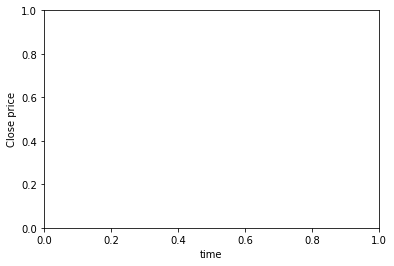

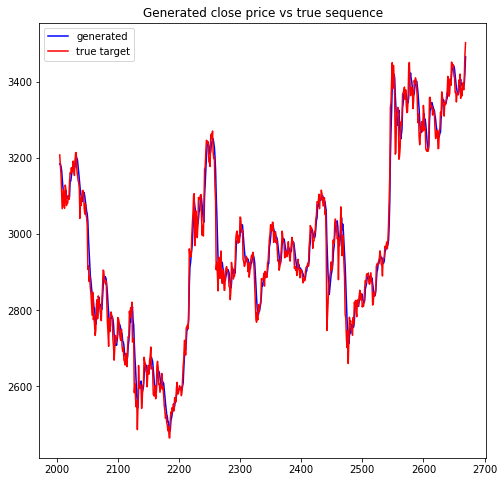

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('time')
plt.ylabel('Close price')
plt.figure(figsize=[8,8])
plt.title('Generated close price vs true sequence')
plt.plot(generated_seqeunce_val*SSE.loc[2000+5:,'STD5_close']+SSE.loc[2000+5:,'MA5_close'],label='generated',c='blue')
plt.plot(SSE.loc[2000+5:,'Close'], label='true target',c='red')
plt.legend()


Text(0, 0.5, 'Train Loss')

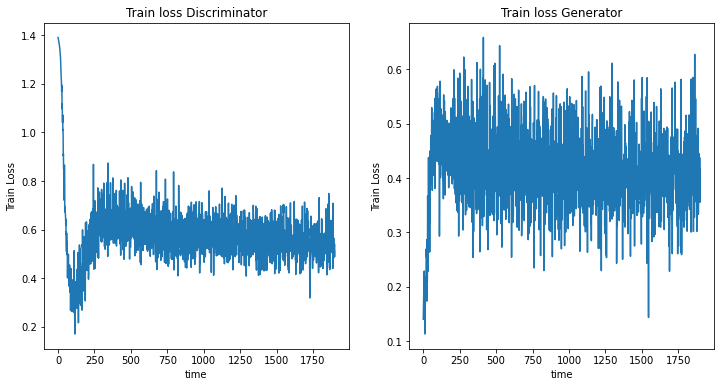

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs=plt.subplots(nrows=1,ncols=2,figsize=[12,6])

axs[0].set_title('Train loss Discriminator')
axs[0].plot(train_loss_disc)
axs[1].set_title('Train loss Generator')
axs[1].plot(train_loss_gen)

#
axs[1].set_xlabel('time')
axs[0].set_xlabel('time')
axs[0].set_ylabel('Train Loss')
axs[1].set_ylabel('Train Loss')

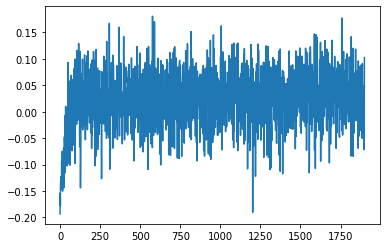

In [39]:
train_all = DataLoader(train_dataset, batch_size=2000, shuffle=True)


for X_all, target in train_all:
  X_all,target=X_all.to(device),target.to(device)
  gen_output=generator(X_all)
 
 

In [40]:
gen_output=gen_output.detach().cpu().numpy()

In [42]:
list(gen_output.squeeze(1))*SSE.loc[6:2000, 'STD5_close']+SSE.loc[6:2000,'MA5_close']

6       3218.273005
7       3224.964438
8       3225.109804
9       3228.399325
10      3226.350244
           ...     
1996    3215.308144
1997    3188.958803
1998    3148.735438
1999    3156.872737
2000    3157.255573
Length: 1995, dtype: float64

Text(0, 0.5, 'closing price')

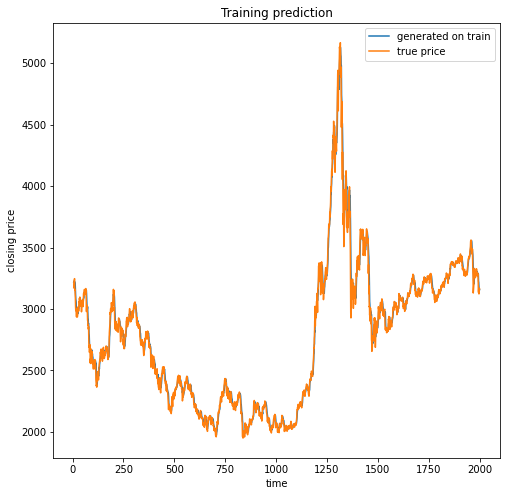

In [44]:
plt.figure(figsize=[8,8])
plt.title('Training prediction')
plt.plot(list(gen_output.squeeze(1))*SSE.loc[6:2000, 'STD5_close']+SSE.loc[6:2000,'MA5_close'] ,label='generated on train')
plt.plot(SSE.loc[6:2000,'Close'],label='true price')
plt.legend()
plt.xlabel('time')
plt.ylabel('closing price')

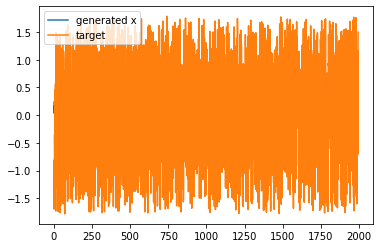

In [21]:

plt.plot(gen_output.detach().cpu(), label='generated x')
plt.plot(target.detach().cpu(), label='target')
plt.legend()

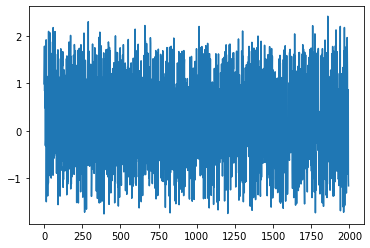

In [22]:
plot_diff=gen_output.squeeze(1).detach().cpu().numpy()-target.detach().cpu().numpy()
plt.plot(plot_diff)

In [23]:
plot_diff.shape

(1995,)

(array([10., 16., 28., 38., 29., 37., 49., 59., 67., 76., 77., 96., 99.,
        89., 80., 47., 53., 48., 47., 47., 44., 49., 38., 58., 62., 80.,
        72., 89., 57., 67., 65., 54., 64., 52., 22., 10.,  9.,  7.,  3.,
         1.]),
 array([-1.7531173 , -1.6488959 , -1.5446744 , -1.4404529 , -1.3362315 ,
        -1.2320101 , -1.1277887 , -1.0235672 , -0.91934574, -0.8151243 ,
        -0.7109028 , -0.60668135, -0.5024599 , -0.39823845, -0.29401702,
        -0.18979555, -0.08557411,  0.01864735,  0.1228688 ,  0.22709025,
         0.3313117 ,  0.43553317,  0.5397546 ,  0.64397603,  0.7481975 ,
         0.85241896,  0.9566404 ,  1.0608618 ,  1.1650833 ,  1.2693048 ,
         1.3735262 ,  1.4777477 ,  1.5819691 ,  1.6861906 ,  1.7904121 ,
         1.8946335 ,  1.9988549 ,  2.1030765 ,  2.2072978 ,  2.3115194 ,
         2.4157407 ], dtype=float32),
 <a list of 40 Patch objects>)

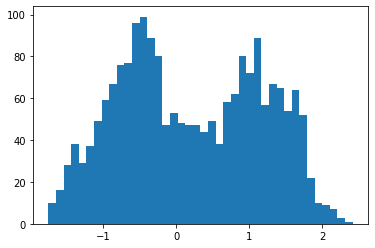

In [25]:
plt.hist(plot_diff,bins=40)